In [1]:
import sys
import numpy as np
sys.path.append('../../')
from src.modeling.Models import Models
from src.preparation.data import Data
from src.modeling.model_based.SurpriseModel import Surprise
from surprise import Reader, SVD, KNNBasic, NMF, BaselineOnly
from surprise.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from math import sqrt
import matplotlib.pyplot as plt
from timeit import default_timer as timer

# Create Model

In [2]:
reader = Reader()
ratings = Data.get_rating()
ratings.drop('timestamp', inplace=True, axis=1)
target = ratings.rating


# 1. SVD
SVDModel = Surprise(SVD(), ratings, reader)
# 2. KNN
sim_options = {'name': 'cosine',
               'shrinkage': 0 # no shrinkage
               }
KNNModel = Surprise(KNNBasic(), ratings, reader)
# 3. NMF
NMF = Surprise(NMF(), ratings, reader)
# 4. Baseline Only
Baseline = Surprise(BaselineOnly(), ratings, reader) 

surpriseLabel = ['SVD', 'KNN', 'NMF', 'Baseline']


# Evaluation

# A. Train Test Split Evaluation

In [3]:
train, test = train_test_split(ratings, test_size=0.2)
RealValue = test.rating

In [4]:
SVDstart = timer()
SVDModel.fit()
SVDPrediction = SVDModel.predict()
SVDend = timer()
print('SVD computation time is ', (SVDend - SVDstart), 'seconds')

SVD computation time is  4.968940082611114 seconds


In [5]:
KNNstart = timer()
KNNModel.fit()
KNNPrediction = KNNModel.predict()
KNNend = timer()

print('KNN computation time is ', (KNNend - KNNstart), 'seconds')

Computing the msd similarity matrix...
Done computing similarity matrix.
KNN computation time is  3.4850539750869025 seconds


In [6]:
NMFstart = timer()
NMF.fit()
NMFPrediction = NMF.predict()
NMFend = timer()

print('NMF computation time is ', (NMFend - NMFstart), 'seconds')

NMF computation time is  4.8217817173718185 seconds


In [7]:
BaselineStart = timer()
Baseline.fit()
BaselinePrediction = NMF.predict()
BaselineEnd = timer()

print('BaselineOnly computation time is ', (BaselineEnd - BaselineStart), 'seconds')

Estimating biases using als...
BaselineOnly computation time is  0.38381163481007086 seconds


In [8]:
# Model Evaluation: RMSE & RECALL

# Evaluate Model rmse
SVDrmse = sqrt(mean_squared_error(RealValue, SVDPrediction))
KNNrmse = sqrt(mean_squared_error(RealValue, KNNPrediction))
NMFrmse = sqrt(mean_squared_error(RealValue, NMFPrediction))
Baselinermse = sqrt(mean_squared_error(RealValue, NMFPrediction))

# Get recommendation and recall of the model
SVDRecall = Models.get_all_recommendations(test, SVDPrediction)
KNNRecall = Models.get_all_recommendations(test, KNNPrediction)
NMFRecall = Models.get_all_recommendations(test, NMFPrediction)
BaselineRecall = Models.get_all_recommendations(test, BaselinePrediction)

RMSE

Text(0, 0.5, 'Model')

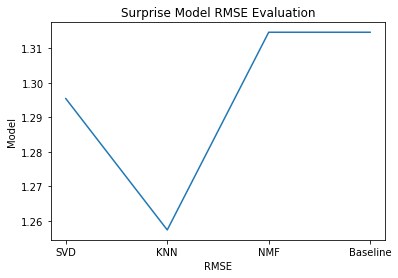

In [9]:
# Plot RMSE
surpriseRMSE = [SVDrmse, KNNrmse, NMFrmse, Baselinermse]

plt.plot(surpriseLabel, surpriseRMSE)
plt.title('Surprise Model RMSE Evaluation')
plt.xlabel('RMSE')
plt.ylabel('Model')


RECALL

Text(0, 0.5, 'Model')

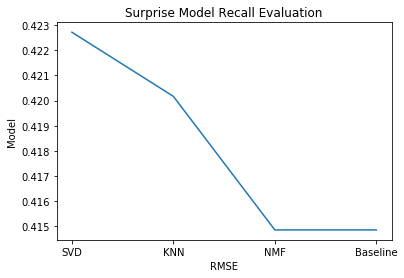

In [10]:
# Plot Recall
surpriseRMSE = [SVDRecall, KNNRecall, NMFRecall, BaselineRecall]

plt.plot(surpriseLabel, surpriseRMSE)
plt.title('Surprise Model Recall Evaluation')
plt.xlabel('RMSE')
plt.ylabel('Model')

# B. CrossValidation Evaluation

RMSE

In [11]:
CrossValLabel = ['Fold1', 'Fold2', 'Fold3', 'Fold4', 'Fold 5']

Mean RMSE fro SVD Cross_Validation is  0.9364261427002353


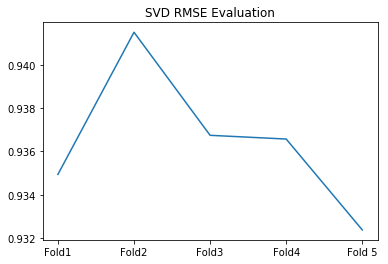

In [12]:
SVDCrossValRmse = SVDModel.cross_val_rmse(5)
plt.plot(CrossValLabel, SVDCrossValRmse)
plt.title('SVD RMSE Evaluation')

SVDRMSEMean = np.mean(SVDCrossValRmse)
print('Mean RMSE fro SVD Cross_Validation is ',SVDRMSEMean)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Mean RMSE fro KNN Cross_Validation is  0.9780996628662058


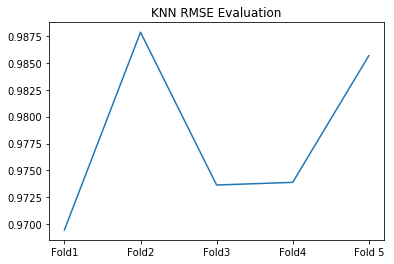

In [13]:
KNNCrossValRmse = KNNModel.cross_val_rmse(5)

plt.plot(CrossValLabel, KNNCrossValRmse)
plt.title('KNN RMSE Evaluation')

KNNRMSEMean = np.mean(KNNCrossValRmse)
print('Mean RMSE fro KNN Cross_Validation is ',KNNRMSEMean)

Mean RMSE fro KNN Cross_Validation is  0.9637660337280346


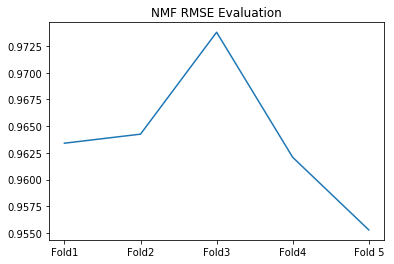

In [14]:
NMFCrossValRmse = NMF.cross_val_rmse(5)
plt.plot(CrossValLabel, NMFCrossValRmse)
plt.title('NMF RMSE Evaluation')

NMFRMSEMean = np.mean(NMFCrossValRmse)
print('Mean RMSE fro KNN Cross_Validation is ',NMFRMSEMean)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Mean RMSE for Baseline Cross_Validation is  0.9442716811616645


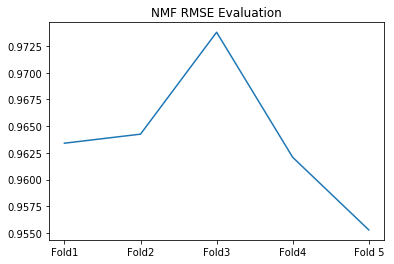

In [15]:
BaselineCrossValRmse = Baseline.cross_val_rmse(5)
plt.plot(CrossValLabel, NMFCrossValRmse)
plt.title('NMF RMSE Evaluation')

BaselineRMSEMean = np.mean(BaselineCrossValRmse)
print('Mean RMSE for Baseline Cross_Validation is ', BaselineRMSEMean)

Text(0.5, 1.0, 'Cross Validation RMSE Evaluation')

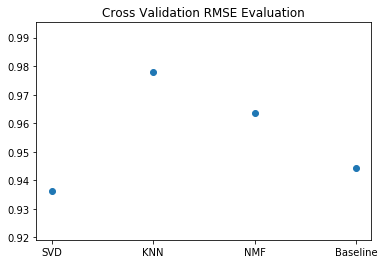

In [16]:
# All together
CrossValRMSEMean = [SVDRMSEMean, KNNRMSEMean, NMFRMSEMean, BaselineRMSEMean]
plt.scatter(surpriseLabel, CrossValRMSEMean)
plt.title('Cross Validation RMSE Evaluation')

RECALL

In [17]:
data = Surprise.read(ratings, reader)
kf = KFold(n_splits=5)

In [18]:
SVDrecalls = []

for trainset, testset in kf.split(data):
    SVDModel.cross_val_fit(trainset)
    predictions = SVDModel.cross_val_predict(testset)
    recalls = SVDModel.cross_val_recall(predictions)
    SVDrecalls.append(sum(rec for rec in recalls.values()) / len(recalls))
    

# Getting mean of SVD recall
SVDRecallMean = sum(SVDrecalls) / len(SVDrecalls)

In [19]:
KNNrecalls = []

for trainset, testset in kf.split(data):
    KNNModel.cross_val_fit(trainset)
    predictions = KNNModel.cross_val_predict(testset)
    recalls = KNNModel.cross_val_recall(predictions)
    KNNrecalls.append(sum(rec for rec in recalls.values()) / len(recalls))
    
KNNRecallMean = sum(KNNrecalls) / len(KNNrecalls)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


In [20]:
NMFrecalls = []

for trainset, testset in kf.split(data):
    NMF.cross_val_fit(trainset)
    predictions = NMF.cross_val_predict(testset)
    recalls = NMF.cross_val_recall(predictions)
    NMFrecalls.append(sum(rec for rec in recalls.values()) / len(recalls))
    
NMFRecallMean = sum(NMFrecalls) / len(NMFrecalls)

In [21]:
Baselinerecalls = []

for trainset, testset in kf.split(data):
    Baseline.cross_val_fit(trainset)
    predictions = Baseline.cross_val_predict(testset)
    recalls = Baseline.cross_val_recall(predictions)
    Baselinerecalls.append(sum(rec for rec in recalls.values()) / len(recalls))

BaselineRecallMean = sum(Baselinerecalls) / len(Baselinerecalls)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


Text(0.5, 1.0, 'Cross Validation Recall Evaluation')

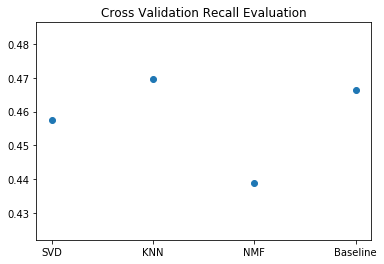

In [22]:
# Plot Recall CrossValidation
CrossValRecallMean = [SVDRecallMean, KNNRecallMean, NMFRecallMean, BaselineRecallMean]
plt.scatter(surpriseLabel, CrossValRecallMean)
plt.title('Cross Validation Recall Evaluation')